In [1]:
import os
import shutil
import gdown
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from collections import Counter
from xml.etree import ElementTree
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image, Video
from ultralytics import YOLO

In [2]:
raw_data_path = 'raw_data'

In [3]:
dior_data_path = 'dior_data'


In [4]:
# Path for all the data
annot_data_path = 'dior_data/Annotations/Horizontal Bounding Boxes'
trainval_data_path = 'dior_data/JPEGImages-trainval'
test_data_path = 'dior_data/JPEGImages-test'

In [6]:
# Creating a list of annotation files
annot_file_list = sorted([os.path.join(annot_data_path, i) for i in os.listdir(annot_data_path) if '.xml' in i])
annot_file_list[:5], annot_file_list[-5:], len(annot_file_list)

(['dior_data/Annotations/Horizontal Bounding Boxes\\00001.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes\\00002.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes\\00003.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes\\00004.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes\\00005.xml'],
 ['dior_data/Annotations/Horizontal Bounding Boxes\\23459.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes\\23460.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes\\23461.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes\\23462.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes\\23463.xml'],
 23463)

In [10]:
print(trainval_data_path)

dior_data/JPEGImages-trainval


In [14]:
# Creating a list of training and validation images
trainval_file_list = sorted([os.path.join(trainval_data_path, i) for i in os.listdir(trainval_data_path) if '.jpg' in i])
trainval_file_list[:5], trainval_file_list[-5:], len(trainval_file_list)

(['dior_data/JPEGImages-trainval\\00001.jpg',
  'dior_data/JPEGImages-trainval\\00002.jpg',
  'dior_data/JPEGImages-trainval\\00003.jpg',
  'dior_data/JPEGImages-trainval\\00004.jpg',
  'dior_data/JPEGImages-trainval\\00005.jpg'],
 ['dior_data/JPEGImages-trainval\\11721.jpg',
  'dior_data/JPEGImages-trainval\\11722.jpg',
  'dior_data/JPEGImages-trainval\\11723.jpg',
  'dior_data/JPEGImages-trainval\\11724.jpg',
  'dior_data/JPEGImages-trainval\\11725.jpg'],
 11725)

In [13]:
import os
import shutil

# Create the directory if it doesn't exist
os.makedirs(dior_data_path, exist_ok=True)

# Iterate over files in the raw data directory
for i in os.listdir(raw_data_path):
    filename = os.path.join(raw_data_path, i) 
    
    # Unpack the archive
    shutil.unpack_archive(filename=filename, extract_dir=dior_data_path)
    
    # Informative print statement
    print(f'[INFO] File "{filename}" has been extracted to "{dior_data_path}".')


[INFO] File "raw_data\Annotations.zip" has been extracted to "dior_data".
[INFO] File "raw_data\JPEGImages-test.zip" has been extracted to "dior_data".
[INFO] File "raw_data\JPEGImages-trainval.zip" has been extracted to "dior_data".


In [15]:
# Creating a list of testing images
test_file_list = sorted([os.path.join(test_data_path, i) for i in os.listdir(test_data_path) if '.jpg' in i])
test_file_list[:5], test_file_list[-5:], len(test_file_list)

(['dior_data/JPEGImages-test\\11726.jpg',
  'dior_data/JPEGImages-test\\11727.jpg',
  'dior_data/JPEGImages-test\\11728.jpg',
  'dior_data/JPEGImages-test\\11729.jpg',
  'dior_data/JPEGImages-test\\11730.jpg'],
 ['dior_data/JPEGImages-test\\23459.jpg',
  'dior_data/JPEGImages-test\\23460.jpg',
  'dior_data/JPEGImages-test\\23461.jpg',
  'dior_data/JPEGImages-test\\23462.jpg',
  'dior_data/JPEGImages-test\\23463.jpg'],
 11738)

In [16]:
# Combining all the images path in one list
image_data_file_list = np.concatenate((trainval_file_list, test_file_list))
image_data_file_list[:5], image_data_file_list[-5:], len(image_data_file_list)

(array(['dior_data/JPEGImages-trainval\\00001.jpg', 'dior_data/JPEGImages-trainval\\00002.jpg', 'dior_data/JPEGImages-trainval\\00003.jpg', 'dior_data/JPEGImages-trainval\\00004.jpg', 'dior_data/JPEGImages-trainval\\00005.jpg'], dtype='<U39'),
 array(['dior_data/JPEGImages-test\\23459.jpg', 'dior_data/JPEGImages-test\\23460.jpg', 'dior_data/JPEGImages-test\\23461.jpg', 'dior_data/JPEGImages-test\\23462.jpg', 'dior_data/JPEGImages-test\\23463.jpg'], dtype='<U39'),
 23463)

In [17]:
# Extracting data from annotation files
meta_list = [] # To store general info for every image
object_list_train = [] # To store object classes info of train dataset
object_list_test = [] # To store object classes info of test dataset

for file in tqdm(annot_file_list):
    meta_dict = {}
    root = ElementTree.parse(file).getroot()
    
    # Filename - extracted
    for path in image_data_file_list:
        if root.find('filename').text in path:
            meta_dict['filename'] = path
            meta_dict['split_type'] = path.split('/')[1]
    
    # Width - extracted
    meta_dict['width'] = int(root.find('size').find('width').text)
    
    # Height - extracted
    meta_dict['height'] = int(root.find('size').find('height').text)
    
    # Objects - extracted and combined into a single string
    meta_dict['objects'] = ', '.join(np.unique([obj.find('name').text for obj in root.findall('object')]))
    meta_list.append(meta_dict)
    
    # Collecting all the object classes instance and counting total appearance
    for obj in root.findall('object'):
        if meta_dict['split_type'] == 'JPEGImages-trainval':
            object_list_train.append(obj.find('name').text)
        elif meta_dict['split_type'] == 'JPEGImages-test':
            object_list_test.append(obj.find('name').text)
    
# Counting the instance for every object class
object_instance_list_train = Counter(sorted(object_list_train))
object_instance_list_test = Counter(sorted(object_list_test))
    
# Collecting Class list and indexing it also in a sequence
class_dict = {k: v for v, k in enumerate(sorted(np.unique(object_list_train)))}

meta_list[:5], object_instance_list_train, object_instance_list_test, class_dict

  0%|          | 0/23463 [00:00<?, ?it/s]

([{'filename': 'dior_data/JPEGImages-trainval\\00001.jpg',
   'split_type': 'JPEGImages-trainval\\00001.jpg',
   'width': 800,
   'height': 800,
   'objects': 'golffield'},
  {'filename': 'dior_data/JPEGImages-trainval\\00002.jpg',
   'split_type': 'JPEGImages-trainval\\00002.jpg',
   'width': 800,
   'height': 800,
   'objects': 'Expressway-toll-station, vehicle'},
  {'filename': 'dior_data/JPEGImages-trainval\\00003.jpg',
   'split_type': 'JPEGImages-trainval\\00003.jpg',
   'width': 800,
   'height': 800,
   'objects': 'trainstation'},
  {'filename': 'dior_data/JPEGImages-trainval\\00004.jpg',
   'split_type': 'JPEGImages-trainval\\00004.jpg',
   'width': 800,
   'height': 800,
   'objects': 'chimney'},
  {'filename': 'dior_data/JPEGImages-trainval\\00005.jpg',
   'split_type': 'JPEGImages-trainval\\00005.jpg',
   'width': 800,
   'height': 800,
   'objects': 'storagetank, vehicle'}],
 Counter(),
 Counter(),
 {})

In [23]:
import os
from collections import Counter
import numpy as np
from xml.etree import ElementTree
from tqdm import tqdm

meta_list = []  # To store general info for every image
object_list_train = []  # To store object classes info of train dataset
object_list_test = []  # To store object classes info of test dataset

for file in tqdm(annot_file_list):
    meta_dict = {}
    root = ElementTree.parse(file).getroot()
    
    # Filename - extracted
    for path in image_data_file_list:
        if root.find('filename').text in os.path.basename(path):
            meta_dict['filename'] = path
            
            # Adjusted split_type extraction to handle path separator issues
            meta_dict['split_type'] = os.path.normpath(path).split(os.sep)[1]
            break
    
    # Width - extracted
    meta_dict['width'] = int(root.find('size').find('width').text)
    
    # Height - extracted
    meta_dict['height'] = int(root.find('size').find('height').text)
    
    # Objects - extracted and combined into a single string
    meta_dict['objects'] = ', '.join(np.unique([obj.find('name').text for obj in root.findall('object')]))
    meta_list.append(meta_dict)
    
    # Collecting all the object classes instance and counting total appearance
    for obj in root.findall('object'):
        if 'trainval' in meta_dict['split_type']:
            object_list_train.append(obj.find('name').text)
        elif 'test' in meta_dict['split_type']:
            object_list_test.append(obj.find('name').text)
    
# Counting the instance for every object class
object_instance_list_train = Counter(sorted(object_list_train))
object_instance_list_test = Counter(sorted(object_list_test))
    
# Collecting Class list and indexing it also in a sequence
class_dict = {k: v for v, k in enumerate(sorted(np.unique(object_list_train)))}

meta_list[:5], object_instance_list_train, object_instance_list_test, class_dict


100%|██████████| 23463/23463 [12:15<00:00, 31.89it/s]


([{'filename': 'dior_data/JPEGImages-trainval\\00001.jpg',
   'split_type': 'JPEGImages-trainval',
   'width': 800,
   'height': 800,
   'objects': 'golffield'},
  {'filename': 'dior_data/JPEGImages-trainval\\00002.jpg',
   'split_type': 'JPEGImages-trainval',
   'width': 800,
   'height': 800,
   'objects': 'Expressway-toll-station, vehicle'},
  {'filename': 'dior_data/JPEGImages-trainval\\00003.jpg',
   'split_type': 'JPEGImages-trainval',
   'width': 800,
   'height': 800,
   'objects': 'trainstation'},
  {'filename': 'dior_data/JPEGImages-trainval\\00004.jpg',
   'split_type': 'JPEGImages-trainval',
   'width': 800,
   'height': 800,
   'objects': 'chimney'},
  {'filename': 'dior_data/JPEGImages-trainval\\00005.jpg',
   'split_type': 'JPEGImages-trainval',
   'width': 800,
   'height': 800,
   'objects': 'storagetank, vehicle'}],
 Counter({'ship': 27351,
          'vehicle': 13725,
          'tenniscourt': 4898,
          'storagetank': 3042,
          'baseballfield': 2384,
      

In [24]:
# Creating a dataframe from the extracted data
meta_df = pd.DataFrame(meta_list)
meta_df

filename           split_type  width  \
0      dior_data/JPEGImages-trainval\00001.jpg  JPEGImages-trainval    800   
1      dior_data/JPEGImages-trainval\00002.jpg  JPEGImages-trainval    800   
2      dior_data/JPEGImages-trainval\00003.jpg  JPEGImages-trainval    800   
3      dior_data/JPEGImages-trainval\00004.jpg  JPEGImages-trainval    800   
4      dior_data/JPEGImages-trainval\00005.jpg  JPEGImages-trainval    800   
...                                        ...                  ...    ...   
23458      dior_data/JPEGImages-test\23459.jpg      JPEGImages-test    800   
23459      dior_data/JPEGImages-test\23460.jpg      JPEGImages-test    800   
23460      dior_data/JPEGImages-test\23461.jpg      JPEGImages-test    800   
23461      dior_data/JPEGImages-test\23462.jpg      JPEGImages-test    800   
23462      dior_data/JPEGImages-test\23463.jpg      JPEGImages-test    800   

       height                                 objects  
0         800                               golffield  
1         800        Expressway-toll-station, vehicle  
2         800                            trainstation  
3         800                                 chimney  
4         800                    storagetank, vehicle  
...       ...                                     ...  
23458     800                                 vehicle  
23459     800  groundtrackfield, tenniscourt, vehicle  
23460     800                       overpass, vehicle  
23461     800                       overpass, vehicle  
23462     800                       overpass, vehicle  

[23463 rows x 5 columns]

In [25]:
print(f'Size of the images width: {meta_df.width.unique()[0]} and height: {meta_df.height.unique()[0]}')
print(f'Total number of classes with all possible combination: {len(meta_df.objects.unique())}')
print(f'Total length of the training/validation dataset: {len(meta_df[meta_df["split_type"] == "JPEGImages-trainval"])} and testing dataset: {len(meta_df[meta_df["split_type"] == "JPEGImages-test"])}')

Size of the images width: 800 and height: 800
Total number of classes with all possible combination: 526
Total length of the training/validation dataset: 11725 and testing dataset: 11738


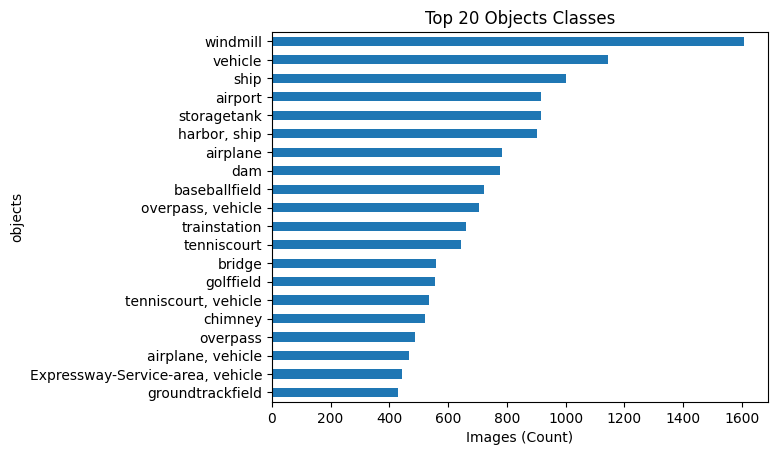

In [26]:
# Top 20 classes in the dataset
meta_df.objects.value_counts()[:20].plot(kind='barh').invert_yaxis()
plt.xlabel('Images (Count)')
plt.title('Top 20 Objects Classes');

In [27]:
plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)
meta_df[meta_df["split_type"] == "JPEGImages-trainval"].objects.value_counts()[:20].plot(kind='barh').invert_yaxis()
plt.xlabel('Images (Count)')
plt.title('Train/Val Dataset', fontsize=16)
plt.subplot(1, 2, 2)
meta_df[meta_df["split_type"] == "JPEGImages-test"].objects.value_counts()[:20].plot(kind='barh').invert_yaxis()
plt.xlabel('Images (Count)')
plt.title('Test Dataset', fontsize=16)
plt.suptitle('Top 20 Objects Classes in the Dataset', fontsize=20, fontweight='bold');

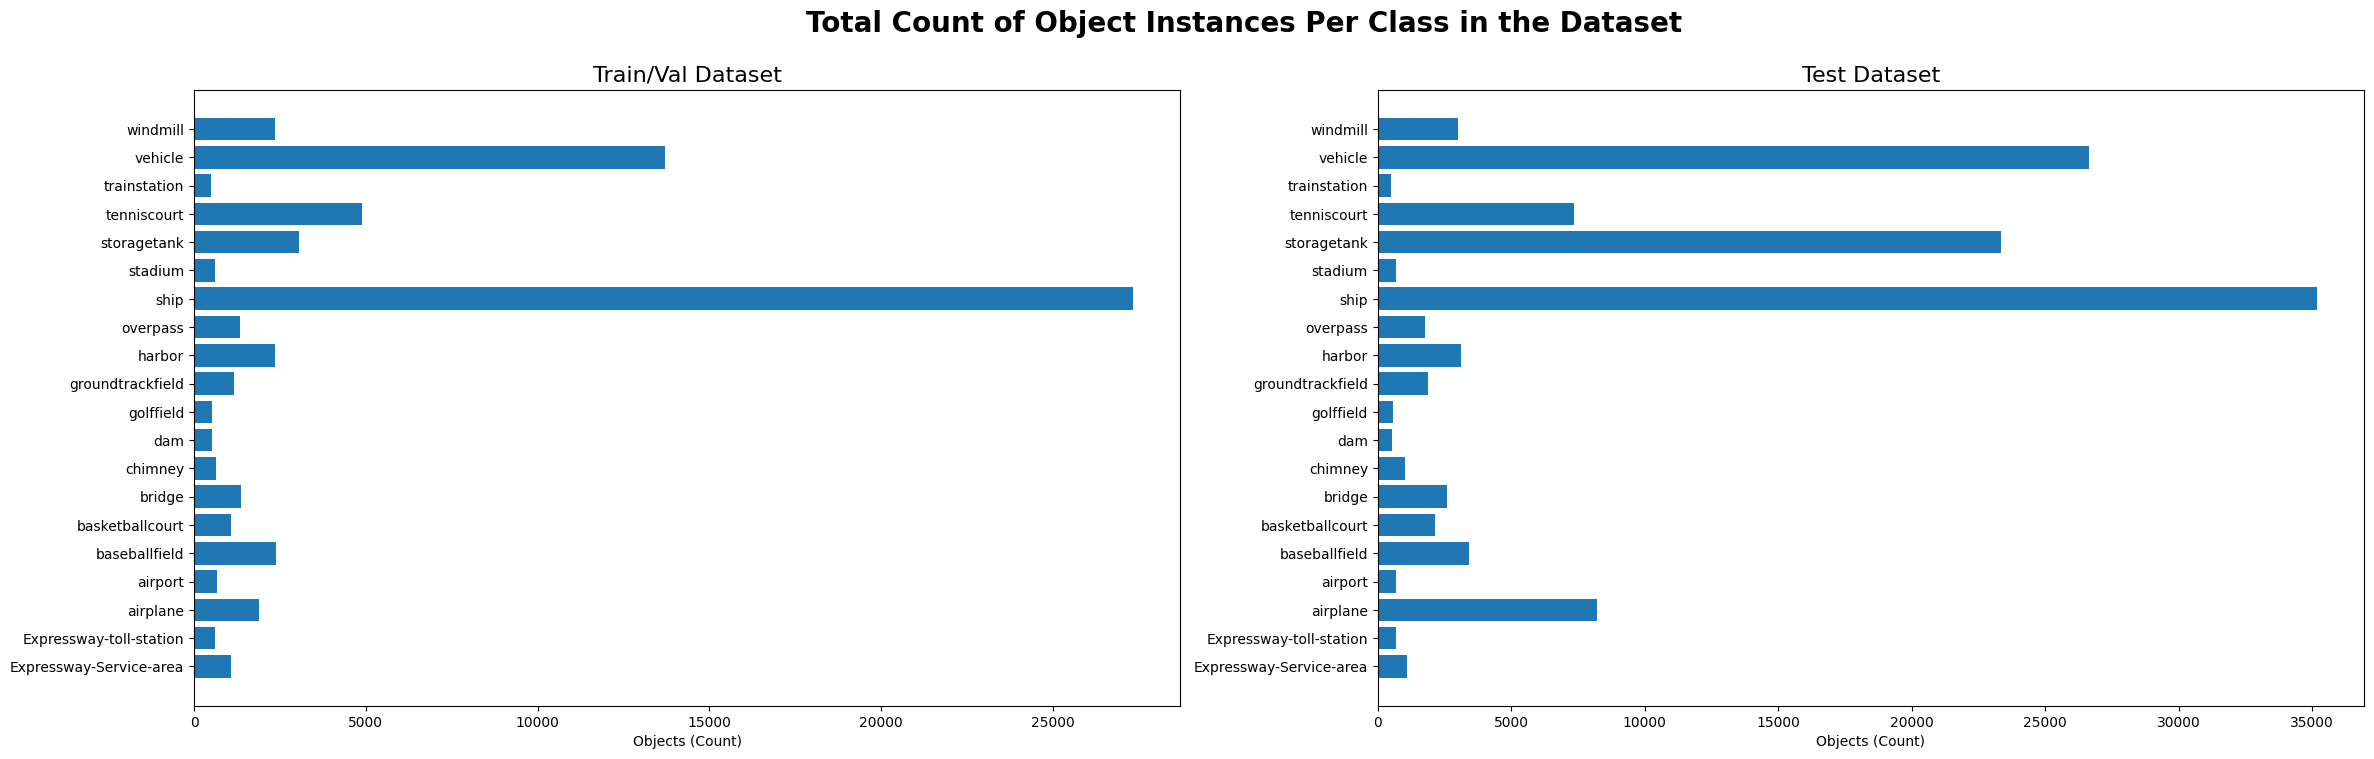

In [28]:
plt.figure(figsize=(28, 8))
plt.subplot(1, 2, 1)
plt.barh(list(object_instance_list_train.keys()), list(object_instance_list_train.values()))
plt.xlabel('Objects (Count)')
plt.title('Train/Val Dataset', fontsize=16)
plt.subplot(1, 2, 2)
plt.barh(list(object_instance_list_test.keys()), list(object_instance_list_test.values()))
plt.xlabel('Objects (Count)')
plt.title('Test Dataset', fontsize=16)
plt.suptitle('Total Count of Object Instances Per Class in the Dataset', fontsize=20, fontweight='bold');

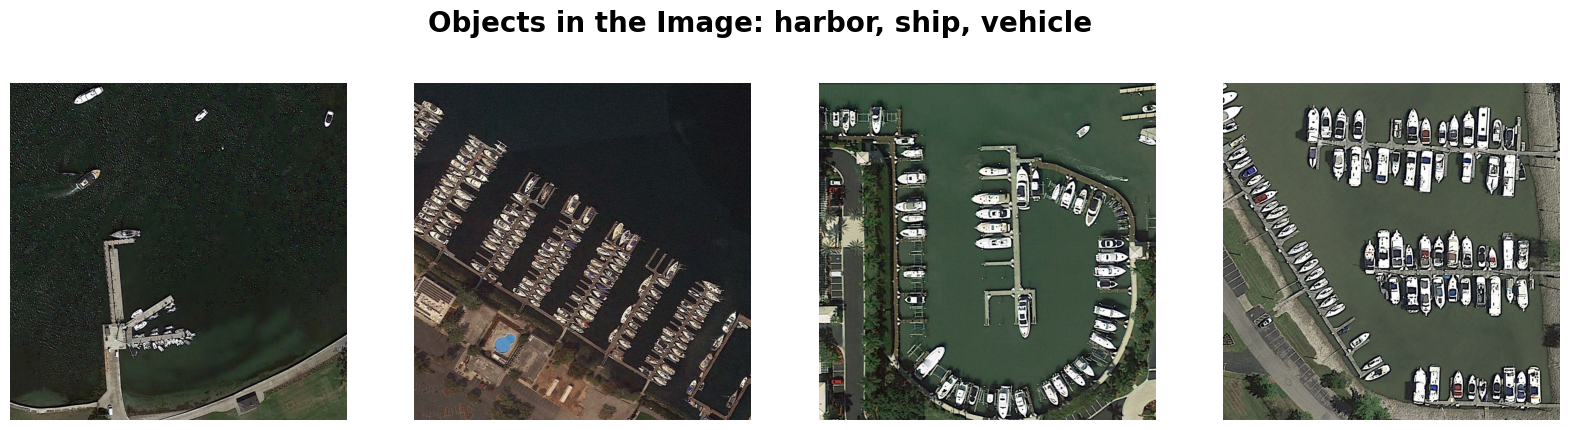

In [29]:
# Visualizing the classes - rerun the code for different classes.
viz_class = random.sample(meta_df.objects.tolist(), 1)[0]
viz_list = meta_df[meta_df['objects'] == viz_class].filename.tolist()
plt.figure(figsize=(20, 5))
rand = random.sample(viz_list, 4)
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(plt.imread(rand[i]))
    plt.suptitle(f'Objects in the Image: {viz_class}', fontsize=20, fontweight='bold')
    plt.axis(False)

In [30]:
# Creating a function for extracting data
def extract_data_from_xml(xml_file: str):
    """
    A function to extract data like filename, size, classes and bboxes from xml file.
    
    Parameters: xml_file: str, A string containing the path to the file.
    
    Returns: data_dict: dict, A dict containing all the extracted data.
    """
    root = ElementTree.parse(xml_file).getroot()
    
    # Creating dict and list to store data
    data_dict = {}
    data_dict['bboxes'] = []
    
    # Reading the xml file
    for element in root:
        # Getting the filename
        if element.tag == 'filename':
            data_dict['filename'] = element.text
        
        # Getting the image size
        elif element.tag == 'size':
            image_size = []
            for size_element in element:
                image_size.append(int(size_element.text))
            data_dict['image_size'] = image_size
        
        # Getting the bounding box
        elif element.tag == 'object':
            bbox = {}
            for obj_element in element:
                # Object or Class name
                if obj_element.tag == 'name':
                    bbox['class'] = obj_element.text
                # Object bounding box 
                elif obj_element.tag == 'bndbox':
                    for bbox_element in obj_element:
                        bbox[bbox_element.tag] = int(bbox_element.text)
            data_dict['bboxes'].append(bbox)
    return data_dict

In [31]:
example = extract_data_from_xml(annot_file_list[1])
example

{'bboxes': [{'class': 'Expressway-toll-station',
   'xmin': 231,
   'ymin': 221,
   'xmax': 303,
   'ymax': 304},
  {'class': 'vehicle', 'xmin': 49, 'ymin': 231, 'xmax': 67, 'ymax': 242},
  {'class': 'vehicle', 'xmin': 54, 'ymin': 252, 'xmax': 72, 'ymax': 262},
  {'class': 'vehicle', 'xmin': 297, 'ymin': 227, 'xmax': 316, 'ymax': 239}],
 'filename': '00002.jpg',
 'image_size': [800, 800, 3]}

In [32]:
#Creating a function to create a YOLO format annotation
def convert_dict_to_yolo(data_dict: dict):
    """
    A function to convert the extracted data dict into a text file as per the YOLO format.
    The final text file is saved in the directory "dior_data/yolo_annotations/data_dict['filename'].txt".
    
    Parameters: data_dict: dict, A dict containing the data.
    """
    data = []
    
    # Reading the bounding box data
    for bbox in data_dict['bboxes']:
        try:
            class_id = class_dict[bbox['class']]
        except KeyError:
            print(f'Invalid Class. Object class: "{bbox["class"]}" not present in the class list.')
            
        # Transforming the bbox in Yolo format [X, Y, W, H]
        img_w, img_h, _ = data_dict['image_size'] # Normalizing the bbox using image size
        
        x_center = ((bbox['xmin'] + bbox['xmax']) / 2) / img_w
        y_center = ((bbox['ymin'] + bbox['ymax']) / 2) / img_h
        width = (bbox['xmax'] - bbox['xmin']) / img_w 
        height = (bbox['ymax'] - bbox['ymin']) / img_h
        
        # Writing the new data to the data list in Yolo format
        data.append(f'{class_id} {x_center:.3f} {y_center:.3f} {width:.3f} {height:.3f}')
        
    # File name for saving the text file(same as xml and jpg file name)
    yolo_annot_dir = os.path.join('dior_data', 'yolo_annotations')
    if not os.path.exists(yolo_annot_dir):
        os.makedirs(yolo_annot_dir)
    save_file_name = os.path.join(yolo_annot_dir, data_dict['filename'].replace('jpg', 'txt'))
    
    # Saving the yolo annotation in a text file
    f = open(save_file_name, 'w+')
    f.write('\n'.join(data))
    f.close()

In [112]:
# Converting all the xml files into Yolo format text files
print('[INFO] Annotation extraction and creation into Yolo has started.')
for annot_file in tqdm(annot_file_list):
    data_dict = extract_data_from_xml(annot_file)
    convert_dict_to_yolo(data_dict)
print('[INFO] All the annotation are converted into Yolo format.')


[INFO] Annotation extraction and creation into Yolo has started.


100%|██████████| 23463/23463 [00:21<00:00, 1111.97it/s]

[INFO] All the annotation are converted into Yolo format.


In [113]:
yolo_annot_path = 'dior_data/yolo_annotations'
yolo_annot_file_list = sorted([os.path.join(yolo_annot_path, i) for i in os.listdir(yolo_annot_path) if '.txt' in i])
yolo_annot_file_list[:5], yolo_annot_file_list[-5:], len(yolo_annot_file_list)

(['dior_data/yolo_annotations\\00001.txt',
  'dior_data/yolo_annotations\\00002.txt',
  'dior_data/yolo_annotations\\00003.txt',
  'dior_data/yolo_annotations\\00004.txt',
  'dior_data/yolo_annotations\\00005.txt'],
 ['dior_data/yolo_annotations\\23459.txt',
  'dior_data/yolo_annotations\\23460.txt',
  'dior_data/yolo_annotations\\23461.txt',
  'dior_data/yolo_annotations\\23462.txt',
  'dior_data/yolo_annotations\\23463.txt'],
 23463)

In [35]:
class_dict_idx = dict(zip(class_dict.values(), class_dict.keys()))
class_dict_idx

{0: 'Expressway-Service-area',
 1: 'Expressway-toll-station',
 2: 'airplane',
 3: 'airport',
 4: 'baseballfield',
 5: 'basketballcourt',
 6: 'bridge',
 7: 'chimney',
 8: 'dam',
 9: 'golffield',
 10: 'groundtrackfield',
 11: 'harbor',
 12: 'overpass',
 13: 'ship',
 14: 'stadium',
 15: 'storagetank',
 16: 'tenniscourt',
 17: 'trainstation',
 18: 'vehicle',
 19: 'windmill'}

In [37]:
def plot_bboxes(img_file: str, annot_file: str, class_dict: dict):
    """
    A function to plot the bounding boxes amd their object classes onto the image.
    
    Parameters:
        img_file: str, A string containing the path to the image file.
        annot_file: str, A string containing the path to the annotation file in yolo format.
        class_dict: dict, A dict containing the classes in the similar sequence as per the annot_file.
    """
    # Reading the image and annot file
    image = cv2.imread(img_file)
    img_h, img_w, _ = image.shape
    
    with open(annot_file, 'r') as f:
        data = f.read().split('\n')
        data = [i.split(' ') for i in data]
        data = [[float(j) for j in i] for i in data]
    
    # Calculating the bbox in Pascal VOC format
    for bbox in data:
        class_idx, x_center, y_center, width, height = bbox
        xmin = int((x_center - width / 2) * img_w)
        ymin = int((y_center - height / 2) * img_h)
        xmax = int((x_center + width / 2) * img_w)
        ymax = int((y_center + height / 2) * img_h)
        
        # Correcting bbox if out of image size
        if xmin < 0:
            xmin = 0
        if ymin < 0:
            ymin = 0
        if xmax > img_w - 1:
            xmax = img_w - 1
        if ymax > img_h - 1:
            ymax = img_h - 1
        
        # Creating the box and label for the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 255, 0), 2)
        cv2.putText(image, class_dict[class_idx], (xmin, 0 if ymin-10 < 0 else ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)
    
    # Displaying the image
    plt.imshow(image)
    plt.axis(False)

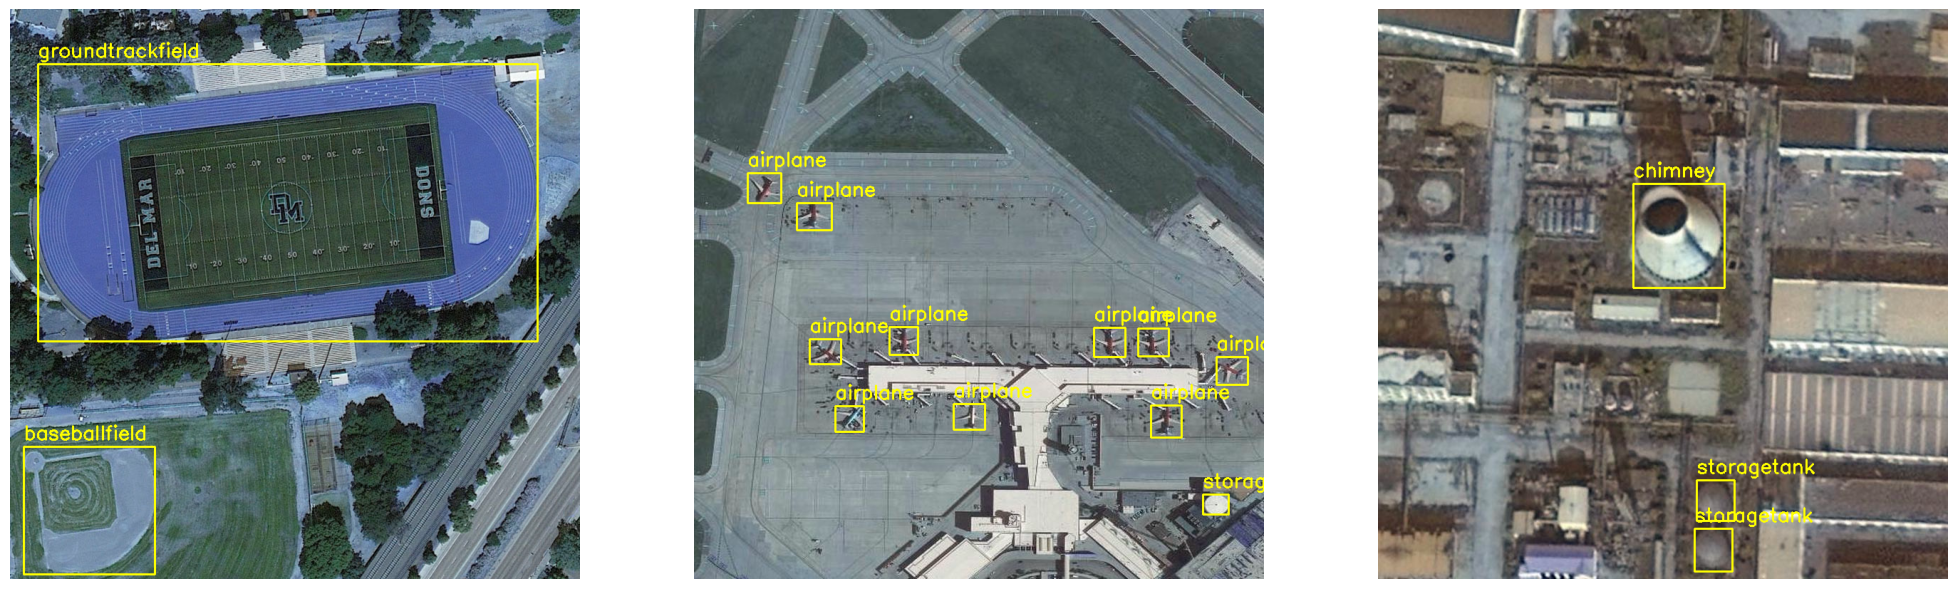

In [38]:
plt.figure(figsize=(25, 8))
rand_int = random.sample(range(len(yolo_annot_file_list)), 3)
for i in range(3):
    plt.subplot(1, 3, i+1)
    plot_bboxes(image_data_file_list[rand_int[i]], yolo_annot_file_list[rand_int[i]], class_dict_idx)

In [39]:
# Creating images and labels directory into the data directory
root_dir = 'datasets'
image_dir = 'datasets/images'
label_dir = 'datasets/labels'
img_train_dir = 'datasets/images/train'
img_val_dir = 'datasets/images/val'
label_train_dir = 'datasets/labels/train'
label_val_dir = 'datasets/labels/val'

# Using 20% of the test dataset for validation
total_val_size = int(len(test_file_list) * 0.2)
total_val_size

2347

In [40]:
# Moving the training images
if not os.path.exists(img_train_dir):
    os.makedirs(img_train_dir)

for filepath in tqdm(trainval_file_list):
    if os.path.isfile(filepath):
        shutil.move(filepath, img_train_dir)

100%|██████████| 11725/11725 [00:11<00:00, 1055.73it/s]


In [41]:
# Moving the Validation images[20% of test dataset]
if not os.path.exists(img_val_dir):
    os.makedirs(img_val_dir)

for filepath in tqdm(test_file_list[:total_val_size]):
    if os.path.isfile(filepath):
        shutil.move(filepath, img_val_dir)

100%|██████████| 2347/2347 [00:02<00:00, 1115.00it/s]


In [50]:
# Moving the training labels
if not os.path.exists(label_train_dir):
    os.makedirs(label_train_dir)

for filepath in tqdm(trainval_file_list):
    file_path = os.path.join('dior_data/yolo_annotations', filepath.replace('jpg', 'txt').split('/')[-1])
    if os.path.isfile(file_path):
        shutil.move(file_path, label_train_dir)

100%|██████████| 11725/11725 [00:00<00:00, 44155.01it/s]


In [55]:

if not os.path.exists(label_train_dir):
    os.makedirs(label_train_dir)

for filepath in tqdm(trainval_file_list):
    file_path = os.path.join('dior_data/yolo_annotations', filepath.replace('jpg', 'txt').split('/')[-1])
    if os.path.isfile(file_path):
        shutil.move(file_path, label_train_dir)

100%|██████████| 11725/11725 [00:00<00:00, 52785.30it/s]


In [69]:
import shutil
import os
from tqdm import tqdm
import random

# Define directories based on the config.yaml file
source_dir = r'C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations'
train_label_dir = r'C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\train'
val_label_dir = r'C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\val'

# Create destination directories if they don't exist
for directory in [train_label_dir, val_label_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# List all annotation files in the source directory
all_files = [f for f in os.listdir(source_dir) if f.endswith('.txt')]

# Shuffle and split files into training and validation sets
random.shuffle(all_files)
split_index = int(0.8 * len(all_files))  # 80% for training, 20% for validation
train_files = all_files[:split_index]
val_files = all_files[split_index:]

# Function to move files
def move_files(file_list, dest_dir):
    for filename in tqdm(file_list):
        file_path = os.path.join(source_dir, filename)
        dest_path = os.path.join(dest_dir, filename)
        
        # Debugging: Print the file path
        print(f"Looking for file: {file_path}")
        
        if os.path.isfile(file_path):
            shutil.move(file_path, dest_path)
            print(f"Moved: {file_path} to {dest_path}")
        else:
            print(f"File not found: {file_path}")

# Move training and validation files
move_files(train_files, train_label_dir)
move_files(val_files, val_label_dir)


0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [70]:
# Loading the model
model = YOLO('yolov8n.yaml') # Builds the model from scratch

# Loading a pretrained model (Not using this for my dataset)
# model = YOLO('yolov8n.pt')

In [74]:
# Define the YAML content as a multi-line string
yaml_content = """
# Path to my dataset
path: C:/Users/MSI/PycharmProjects/pythonProject1/pythonProject/datasets  # Root directory of your dataset

train: images/train  # Directory containing training images
val: images/val      # Directory containing validation images

# Classes as per mentioned in the annotation
names:
  0: Expressway-Service-area
  1: Expressway-toll-station
  2: airplane
  3: airport
  4: baseballfield
  5: basketballcourt
  6: bridge
  7: chimney
  8: dam
  9: golffield
  10: groundtrackfield
  11: harbor
  12: overpass
  13: ship
  14: stadium
  15: storagetank
  16: tenniscourt
  17: trainstation
  18: vehicle
  19: windmill
"""

# Specify the path to the YAML file
yaml_file_path = 'config.yaml'

# Write the content to the YAML file
with open(yaml_file_path, 'w') as file:
    file.write(yaml_content)

print(f"YAML file has been written to {yaml_file_path}")


YAML file has been written to config.yaml


In [76]:
# Training the model for 1 epoch
results = model.train(data='config.yaml', imgsz=800, epochs=5, batch=16, name='yolov8n_epochs50_batch16')

Ultralytics YOLOv8.2.82  Python-3.9.18 torch-2.4.0+cpu CPU (11th Gen Intel Core(TM) i7-11800H 2.30GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=config.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_epochs50_batch1622, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

train: Scanning C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\train.cache... 9350 images, 2375 backgrounds, 0 corrupt: 100%|██████████| 11725/11725 [00:00<?, ?it/s]

train: WARNING  C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\images\train\00594.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\val.cache... 486 images, 1861 backgrounds, 0 corrupt: 100%|██████████| 2347/2347 [00:00<?, ?it/s]

Plotting labels to runs\detect\yolov8n_epochs50_batch1622\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 800 train, 800 val
Using 0 dataloader workers
Logging results to runs\detect\yolov8n_epochs50_batch1622
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      3.414      5.397      3.947         42        800: 100%|██████████| 733/733 [1:21:57<00:00,  6.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [07:33<00:00,  6.14s/it]


                   all       2347       5482      0.556     0.0165    0.00217   0.000701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      2.685      4.105      2.887        168        800: 100%|██████████| 733/733 [1:20:12<00:00,  6.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [07:51<00:00,  6.38s/it]


                   all       2347       5482      0.449     0.0583     0.0174       0.01

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      2.167      3.224      2.286         46        800: 100%|██████████| 733/733 [1:19:11<00:00,  6.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [07:24<00:00,  6.00s/it]


                   all       2347       5482      0.518     0.0926      0.029      0.016

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.947      2.735      2.019         60        800: 100%|██████████| 733/733 [1:19:48<00:00,  6.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [07:16<00:00,  5.90s/it]


                   all       2347       5482      0.281      0.146     0.0425      0.023

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.839      2.485      1.898        102        800: 100%|██████████| 733/733 [1:20:22<00:00,  6.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [07:21<00:00,  5.97s/it]


                   all       2347       5482      0.228      0.161     0.0481     0.0255

5 epochs completed in 7.320 hours.
Optimizer stripped from runs\detect\yolov8n_epochs50_batch1622\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\yolov8n_epochs50_batch1622\weights\best.pt, 6.3MB

Validating runs\detect\yolov8n_epochs50_batch1622\weights\best.pt...
Ultralytics YOLOv8.2.82  Python-3.9.18 torch-2.4.0+cpu CPU (11th Gen Intel Core(TM) i7-11800H 2.30GHz)
YOLOv8n summary (fused): 168 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [05:16<00:00,  4.28s/it]


                   all       2347       5482      0.228      0.161     0.0479     0.0255
Expressway-Service-area         22         40     0.0635      0.025    0.00904    0.00206
Expressway-toll-station         18         18     0.0723      0.111     0.0234     0.0143
              airplane         23        321     0.0749     0.0748     0.0158    0.00919
               airport         31         31          1          0    0.00125   0.000484
         baseballfield         70        209      0.199      0.507      0.142      0.104
       basketballcourt         32        119       0.14      0.084     0.0519     0.0297
                bridge         41        131          0          0     0.0028    0.00114
               chimney         17         35      0.124      0.486      0.185     0.0911
                   dam         23         24          1          0     0.0029    0.00123
             golffield         26         30     0.0172     0.0333    0.00913    0.00313
      groundtrackfi

In [77]:
# Creating a test directory
img_test_dir = 'datasets/images/test'

# Moving the Testing images[80% of test dataset]
if not os.path.exists(img_test_dir):
    os.makedirs(img_test_dir)

test_list = os.listdir('dior_data/JPEGImages-test')
for filename in tqdm(test_list):
    filepath = os.path.join('dior_data/JPEGImages-test', filename)
    if os.path.isfile(filepath):
        shutil.move(filepath, img_test_dir)

100%|██████████| 9391/9391 [00:13<00:00, 722.31it/s]


In [117]:
import os
import shutil
from tqdm import tqdm

# Define paths
label_test_dir = r"C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test"
source_labels_dir = r"C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations"
test_images_dir = r"C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\images\test"

# Ensure the test labels directory exists
if not os.path.exists(label_test_dir):
    os.makedirs(label_test_dir)

# List of test image filenames
test_list = os.listdir(test_images_dir)

# Move label files corresponding to test images
for filename in tqdm(test_list):
    # Create corresponding label filename
    label_filename = filename.replace('jpg', 'txt')
    label_filepath = os.path.join(source_labels_dir, label_filename)
    
    # Move the label file if it exists
    if os.path.isfile(label_filepath):
        shutil.move(label_filepath, label_test_dir)
        print(f"Moved: {label_filepath} to {label_test_dir}")
    else:
        print(f"Label file not found: {label_filepath}")


  2%|▏         | 167/9391 [00:00<00:05, 1628.02it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14073.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14074.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14075.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14076.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14077.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

  5%|▌         | 515/9391 [00:00<00:06, 1329.44it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14421.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14422.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14423.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14424.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14425.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

  9%|▉         | 841/9391 [00:00<00:06, 1424.42it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14675.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14676.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14677.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14678.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14679.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 12%|█▏        | 1161/9391 [00:00<00:05, 1403.17it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14980.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14981.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14982.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14983.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\14984.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 14%|█▍        | 1303/9391 [00:00<00:05, 1372.83it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\15234.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\15235.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\15236.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\15237.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\15238.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 18%|█▊        | 1703/9391 [00:01<00:04, 1542.32it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\15598.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\15599.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\15600.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\15601.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\15602.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 22%|██▏       | 2108/9391 [00:01<00:04, 1676.82it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\15846.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\15847.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\15848.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\15849.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\15850.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 26%|██▌       | 2441/9391 [00:01<00:04, 1624.50it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\16291.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\16292.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\16293.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\16294.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\16295.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 31%|███       | 2867/9391 [00:01<00:03, 1770.56it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\16622.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\16623.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\16624.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\16625.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\16626.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 35%|███▍      | 3271/9391 [00:02<00:03, 1866.30it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\17005.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\17006.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\17007.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\17008.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\17009.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 39%|███▉      | 3645/9391 [00:02<00:03, 1696.13it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\17393.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\17394.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\17395.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\17396.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\17397.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 41%|████      | 3818/9391 [00:02<00:03, 1550.35it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\17718.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\17719.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\17720.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\17721.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\17722.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 45%|████▍     | 4200/9391 [00:02<00:03, 1672.66it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18033.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18034.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18035.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18036.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18037.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 48%|████▊     | 4545/9391 [00:02<00:03, 1539.80it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18376.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18377.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18378.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18379.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18380.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 52%|█████▏    | 4872/9391 [00:03<00:03, 1362.27it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18719.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18720.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18721.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18722.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18723.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 56%|█████▌    | 5225/9391 [00:03<00:02, 1563.18it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18945.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18946.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18947.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18948.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\18949.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 59%|█████▉    | 5577/9391 [00:03<00:02, 1660.58it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\19298.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\19299.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\19300.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\19301.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\19302.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 63%|██████▎   | 5921/9391 [00:03<00:02, 1668.47it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\19650.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\19651.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\19652.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\19653.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\19654.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 65%|██████▍   | 6090/9391 [00:03<00:02, 1510.29it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\19994.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\19995.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\19996.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\19997.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\19998.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 68%|██████▊   | 6417/9391 [00:04<00:01, 1524.01it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\20276.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\20277.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\20278.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\20279.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\20280.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 72%|███████▏  | 6769/9391 [00:04<00:01, 1640.78it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\20632.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\20633.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\20634.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\20635.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\20636.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 77%|███████▋  | 7189/9391 [00:04<00:01, 1823.22it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21072.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21073.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21074.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21075.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21076.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 80%|████████  | 7536/9391 [00:04<00:01, 1565.34it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21383.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21384.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21385.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21386.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21387.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 84%|████████▍ | 7905/9391 [00:04<00:00, 1642.75it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21673.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21674.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21675.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21676.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21677.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 86%|████████▌ | 8081/9391 [00:05<00:00, 1671.65it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21978.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21979.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21980.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21981.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\21982.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 90%|████████▉ | 8429/9391 [00:05<00:00, 1678.36it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\22324.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\22325.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\22326.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\22327.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\22328.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 94%|█████████▍| 8812/9391 [00:05<00:00, 1763.08it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\22639.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\22640.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\22641.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\22642.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\22643.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

 98%|█████████▊| 9205/9391 [00:05<00:00, 1849.29it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\23024.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\23025.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\23026.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\23027.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\23028.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

100%|██████████| 9391/9391 [00:05<00:00, 1609.16it/s]

Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\23383.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\23384.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\23385.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\23386.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_annotations\23387.txt to C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test
Moved: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\dior_data\yolo_

In [118]:

%%writefile test_config.yaml
# Path to my dataset
path: C:/Users/MSI/PycharmProjects/pythonProject1/pythonProject/datasets  # Root directory of your dataset

train: images/train  # Directory containing training images
val: images/test      # Directory containing validation images

# Classes as per mentioned in the annotation
names:
  0: Expressway-Service-area
  1: Expressway-toll-station
  2: airplane
  3: airport
  4: baseballfield
  5: basketballcourt
  6: bridge
  7: chimney
  8: dam
  9: golffield
  10: groundtrackfield
  11: harbor
  12: overpass
  13: ship
  14: stadium
  15: storagetank
  16: tenniscourt
  17: trainstation
  18: vehicle
  19: windmill 

Overwriting test_config.yaml


In [119]:
model = YOLO(r"C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\runs\detect\yolov8n_epochs50_batch1622\weights\best.pt")


In [120]:
test_results = model.val(data='test_config.yaml', imgsz=800, name='yolov8n_val_on_test')


Ultralytics YOLOv8.2.82  Python-3.9.18 torch-2.4.0+cpu CPU (11th Gen Intel Core(TM) i7-11800H 2.30GHz)
YOLOv8n summary (fused): 168 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test... 9391 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9391/9391 [00:07<00:00, 1321.43it/s]


val: New cache created: C:\Users\MSI\PycharmProjects\pythonProject1\pythonProject\datasets\labels\test.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 587/587 [19:11<00:00,  1.96s/it]


                   all       9391      98630      0.461      0.216        0.2      0.111
Expressway-Service-area        447        860      0.421     0.0733      0.115     0.0396
Expressway-toll-station        516        561      0.213     0.0998     0.0615     0.0371
              airplane        566       6423      0.612      0.183      0.239      0.134
               airport        530        538          1          0     0.0106    0.00306
         baseballfield       1030       2699      0.666      0.588       0.58      0.418
       basketballcourt        559       1677      0.622      0.114      0.198      0.114
                bridge       1034       2061      0.218    0.00825      0.026     0.0114
               chimney        359        838      0.423      0.426      0.381      0.207
                   dam        408        435          1          0    0.00918    0.00332
             golffield        396        465     0.0892      0.224     0.0522     0.0171
      groundtrackfi

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\MSI\\PycharmProjects\\pythonProject1\\pythonProject\\Users\\MSI\\PycharmProjects\\pythonProject1\\pythonProject\\runs\\detect\\yolov8n_val_on_test3\\val_batch0_labels.jpg'

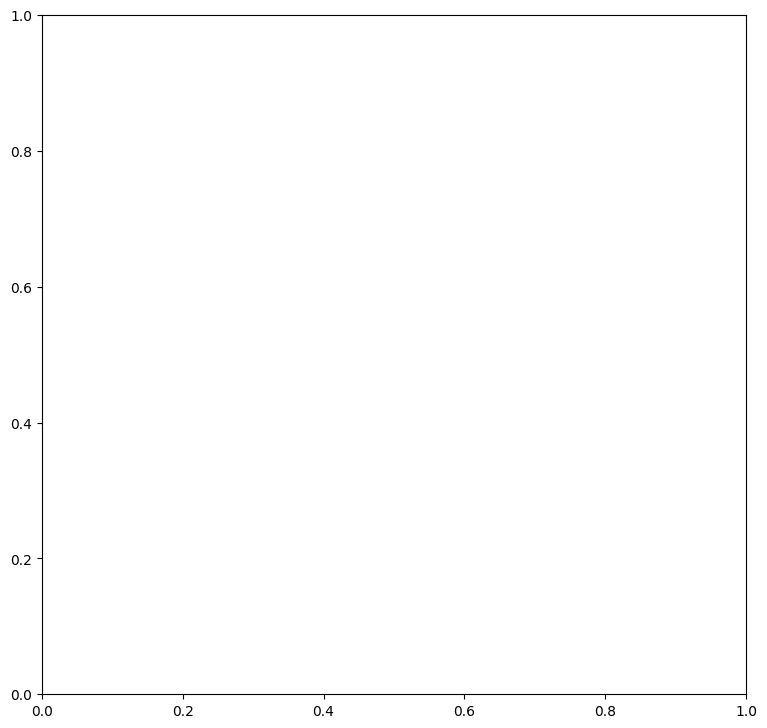

In [121]:
import matplotlib.pyplot as plt

# List of validation result images (left are true labels, right are predictions)
val_result_image = [
    'Users/MSI/PycharmProjects/pythonProject1/pythonProject/runs/detect/yolov8n_val_on_test3/val_batch0_labels.jpg',
    'Users/MSI/PycharmProjects/pythonProject1/pythonProject/runs/detect/yolov8n_val_on_test3/val_batch0_pred.jpg',
    'Users/MSI/PycharmProjects/pythonProject1/pythonProject/runs/detect/yolov8n_val_on_test3/val_batch1_labels.jpg',
    'Users/MSI/PycharmProjects/pythonProject1/pythonProject/runs/detect/yolov8n_val_on_test3/val_batch1_pred.jpg',
    'Users/MSI/PycharmProjects/pythonProject1/pythonProject/runs/detect/yolov8n_val_on_test3/val_batch2_labels.jpg',
    'Users/MSI/PycharmProjects/pythonProject1/pythonProject/runs/detect/yolov8n_val_on_test3/val_batch2_pred.jpg'
]

# Plotting the images in a 3x2 grid
plt.figure(figsize=(20, 30))

for i in range(len(val_result_image)):
    plt.subplot(3, 2, i + 1)
    img = plt.imread(val_result_image[i])
    plt.imshow(img)
    plt.axis('off')  # Hide the axis

plt.show()


In [5]:
# Choosing a random images from the test dataset
img_test_dir = 'datasets/images/test'
label_test_dir = 'datasets/labels/test'
rand_img = random.sample(os.listdir(img_test_dir), 1)[0]
rand_img_path = os.path.join(img_test_dir, rand_img)
rand_label_path = os.path.join(label_test_dir, rand_img).replace('jpg', 'txt')

# Predicting the object using the yolo model
pred_list = model.predict(source=rand_img_path, imgsz=800, save=True, conf=0.5)
pred_img_path = os.path.join('runs/detect/predict3', rand_img) # Predict path can change

# Ploting a the true and predicted images with bounding boxes
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plot_bboxes(rand_img_path, rand_label_path, class_dict_idx)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(plt.imread(pred_img_path))
plt.title('Predicted Image')
plt.axis(False);

NameError: name 'model' is not defined